In [1]:
import math
import random
import torch
import numpy as np
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import copy
import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm



from scipy.interpolate import griddata

D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#global veriable 
Uniform_low_bound=0
Uniform_up_bound=1
Agent_number_n=10
Normal_loc=0.5
Normal_scale=0.2
Normal_loc1=0.15
Normal_loc2=0.85
Normal_scale1=0.1
Normal_scale2=0.1
Distribution_number=10000


[0.06925207 0.35707063 0.81282955 0.42770483 0.59985444 0.72816128
 0.82122761 0.76051512 0.00714328 0.42025683]
[[0.97347557 0.95538345 0.42462553 ... 0.63650234 0.76108474 0.18802993]
 [0.23783677 0.66459076 0.3741999  ... 0.21199017 0.93517469 0.31604711]
 [0.45861424 0.9552804  0.6050889  ... 0.13753772 0.24868187 0.3719452 ]
 ...
 [0.36591559 0.68718776 0.09936429 ... 0.96846719 0.54219851 0.25576897]
 [0.2871301  0.10456257 0.08067045 ... 0.14154302 0.6780894  0.82744162]
 [0.19329161 0.93503464 0.27339873 ... 0.50301997 0.57779921 0.1298519 ]]
[0.97347557 0.23783677 0.45861424 ... 0.36591559 0.2871301  0.19329161]


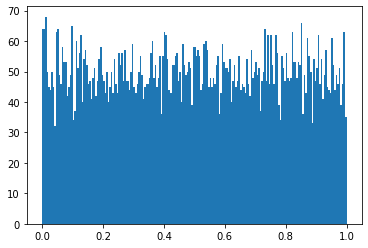

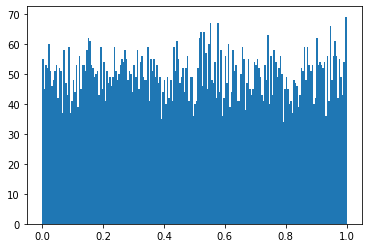

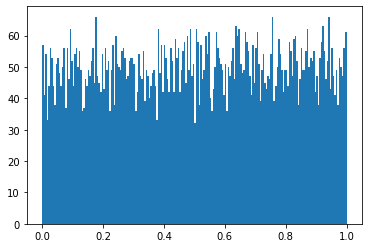

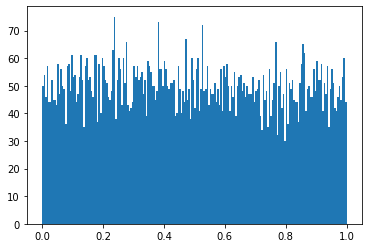

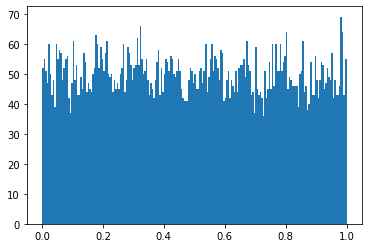

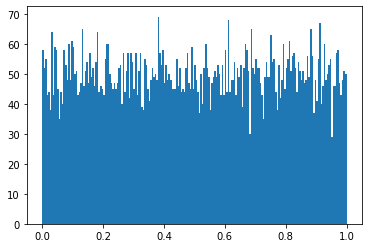

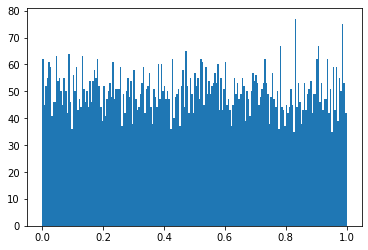

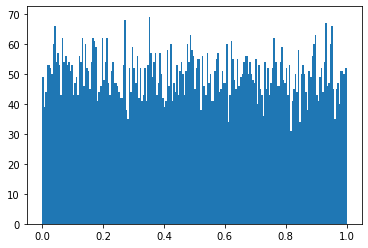

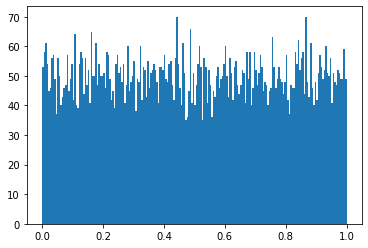

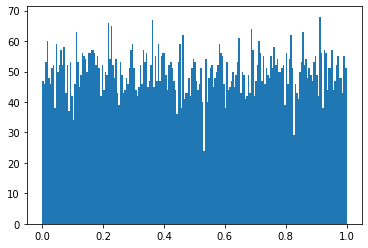

1000
9000


In [3]:
seed = 7
np.random.seed(seed)
exec(open('distribution/uniform.py').read())
#exec(open('distribution/normal.py').read())
X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
#run_cs()

In [4]:
#GCSOD

def cost_sharing_with_deadline(test,t_c):
    temp_max_delay=0
    temp_sum_delay=0
    result=False

    for k in range(len(test),0,-1):
        count=0;
        delay=0;
        for item in test:
            if(item>=1.0/k):
                count+=1;
            else:
                delay+=t_c;
        if(count>=k):
            temp_sum_delay+=delay;
            if(k!=len(test)):
                temp_max_delay=t_c
            result=True
            break;
        if(k<=1):
            #print(test,number_n);
            temp_max_delay=1
            temp_sum_delay=len(test);
            result=False
            
            
    return temp_max_delay,temp_sum_delay,result

def cost_sharing_with_optimal_deadline(group_data):
    group_data=np.sort(group_data)
    t_c_list=[]
    for i in range(len(group_data)):
        t_c_list.append( 1.0/(group_data[i]*(len(group_data)-i))+1e-8 )
        
        
    #print(group_data,t_c_list,group_data[0],len(group_data),1.0/(group_data[0]*(len(group_data)-0)))
    
    optimal_max_t_c=1e9
    optimal_sum_t_c=1e9

    
    for ii in range(len(group_data)):
        temp_test=[]
        if(t_c_list[ii]<=1):
            for i in range(0,ii):
                temp_test.append(0)
            
            for i in range(ii,len(group_data)):
                temp_test.append(group_data[i]*(t_c_list[ii]))
                
            temp_max_delay,temp_sum_delay,judge1 = cost_sharing_with_deadline(temp_test,t_c_list[ii])
            
            if(judge1):
                if optimal_sum_t_c > t_c_list[ii]:
                    optimal_max_t_c = t_c_list[ii]

                if optimal_sum_t_c > t_c_list[ii]:
                    optimal_sum_t_c = t_c_list[ii]

        
    if(optimal_max_t_c>1):
        optimal_max_t_c=1
    
    if(optimal_sum_t_c>1):
        optimal_sum_t_c=1
    return optimal_max_t_c,optimal_sum_t_c


total_delay=0
test_number=0
op_test=[0.0, 0.0, 0.34, 0.99, 0.99]
for i in range(1):
    print(cost_sharing_with_optimal_deadline(op_test))


(0.5050505150505051, 0.5050505150505051)


<ipython-input-4-0e2c0e8aed7e>:35: RuntimeWarning: divide by zero encountered in double_scalars
  t_c_list.append( 1.0/(group_data[i]*(len(group_data)-i))+1e-8 )


In [5]:


def run_GCSOD():
    max_delay=0
    sum_delay=0
    test_number=0
    for i in range(len(X_test)):
        test_number+=1
        test=X_test[i];
        temp_group_a=[]
        temp_group_b=[]
        
        for k in range(Agent_number_n):
            if(random.randint(0, 1)):
                temp_group_a.append(test[k])
            else:
                temp_group_b.append(test[k])
                
        temp_group_a_t_c_max,temp_group_a_t_c_sum=cost_sharing_with_optimal_deadline(temp_group_a)
            
        temp_group_b_t_c_max,temp_group_b_t_c_sum=cost_sharing_with_optimal_deadline(temp_group_b)

        if temp_group_a_t_c_max <= temp_group_b_t_c_max: #group a success
            test=copy.deepcopy(temp_group_a)
            for j in range(len(temp_group_a)):
                test[j]=temp_group_a[j]*temp_group_b_t_c_max
            temp_max_delay,waste,judge1=cost_sharing_with_deadline(test,temp_group_b_t_c_max)

            
            for j in range(len(temp_group_a)):
                test[j]=temp_group_a[j]*temp_group_b_t_c_sum
            
            waste,temp_sum_delay,judge2=cost_sharing_with_deadline(test,temp_group_b_t_c_sum)
            
            
            if(len(temp_group_b)!=0):
                temp_max_delay = max(temp_max_delay,temp_group_a_t_c_max)
                
            temp_sum_delay = temp_sum_delay+temp_group_a_t_c_sum*len(temp_group_b)

            #max_delay+=min(temp_group_a_t_c_max,temp_group_b_t_c_max)
            max_delay+=temp_max_delay
            

                

            sum_delay+=temp_sum_delay
            
        else: #group b success
            test=copy.deepcopy(temp_group_b)
            for j in range(len(temp_group_b)):
                test[j]=temp_group_b[j]*temp_group_a_t_c_max
                

            temp_max_delay,waste,judge1=cost_sharing_with_deadline(test,temp_group_a_t_c_max)
            
            for j in range(len(temp_group_b)):
                test[j]=temp_group_b[j]*temp_group_a_t_c_sum
                
            waste,temp_sum_delay,judge2=cost_sharing_with_deadline(test,temp_group_a_t_c_sum)
            
            if(len(temp_group_a)!=0):
                temp_max_delay=max(temp_max_delay,temp_group_b_t_c_max)
            
            temp_sum_delay=temp_sum_delay+temp_group_b_t_c_sum*len(temp_group_a)
               
            #max_delay+=min(temp_group_a_t_c_max,temp_group_b_t_c_max)
            max_delay+=temp_max_delay

            
            sum_delay+=temp_sum_delay
            
#         if(nn<10):#temp_group_a_t_c_max<=0.5 and temp_group_b_t_c_max==1  and 
#                 nn+=1
#                 print(temp_group_a)
#                 print(temp_group_b)
#                 print()
#                 print("temp_group_a_t_c_max",temp_group_a_t_c_max)
#                 print("temp_group_a_t_c_sum",temp_group_a_t_c_sum)
#                 print("temp_group_b_t_c_max",temp_group_b_t_c_max)
#                 print("temp_group_b_t_c_sum",temp_group_b_t_c_sum)
#                 print("result:",temp_max_delay,temp_sum_delay)
#                 print(temp_sum_delay,temp_group_a_t_c_sum,len(temp_group_b))
#                 print()
#                 print()
        
    print("max_delay",max_delay/test_number);
    print("sum_delay",sum_delay/test_number);

run_GCSOD()

max_delay 0.6885688443583831
sum_delay 3.044111809103446


In [6]:
#Cost Sharing
def run_cs():
    sum_delay=0
    max_delay=0
    test_number=0
    for i in range(len(X_test)):
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test=X_test[i];
        
        for k in range(Agent_number_n,0,-1):
            count=0;
            delay=0;
            for item in test:
                if(item>=1.0/k):
                    count+=1;
                else:
                    delay+=1;
            if(count>=k):
                temp_delay=delay;
                if temp_delay != 0 :
                    temp_max_delay = 1
                break;
            if(k<=1):
                #print(test);
                temp_delay=Agent_number_n;
                temp_max_delay=1
        sum_delay+=temp_delay
        max_delay+=temp_max_delay
                
    print("max_delay",max_delay/test_number);
    print("sum_delay",sum_delay/test_number);
    
run_cs()

max_delay 0.6561111111111111
sum_delay 1.1436666666666666


[0.46079454 0.38184604 0.44005775 0.75937704 0.80591593 0.63388364
 0.60974902 0.6353258  0.49755156 0.48486731]
[[0.87201113 0.20054527 0.59526754 ... 0.33755828 0.33658395 0.53846154]
 [0.47846659 0.21971507 0.46661005 ... 0.69515653 0.40636836 0.30079682]
 [0.56450355 0.21218269 0.57814536 ... 0.28712334 0.21701084 0.37076454]
 ...
 [0.39557357 0.62140959 0.36981403 ... 0.54457435 0.50170501 0.32225437]
 [0.57262304 0.62922796 0.61420577 ... 0.38864646 0.50550212 0.69513955]
 [0.57434091 0.15524742 0.74025506 ... 0.48198306 0.50895046 0.47774852]]
[0.87201113 0.47846659 0.56450355 ... 0.39557357 0.57262304 0.57434091]


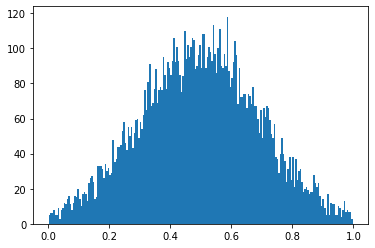

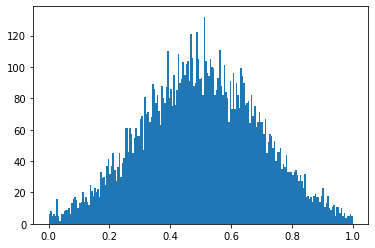

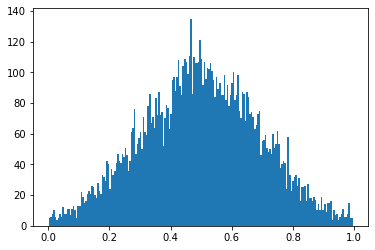

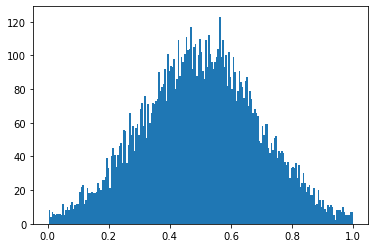

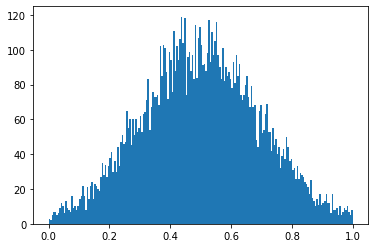

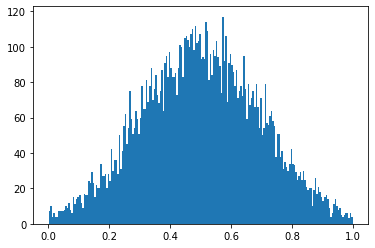

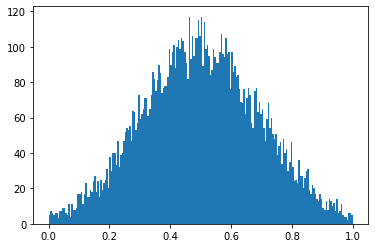

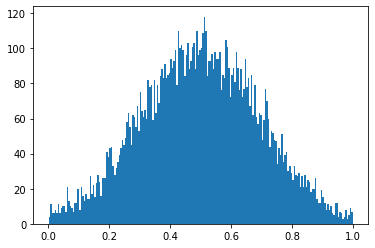

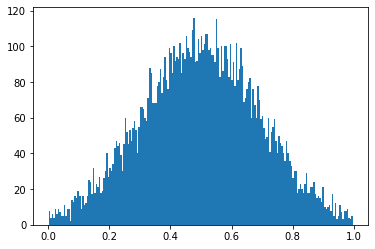

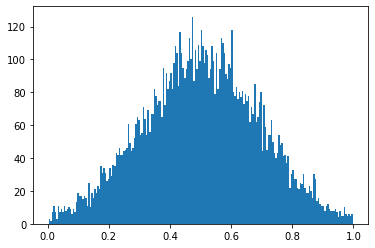

1000
9000
max_delay 0.5403444231900985
sum_delay 2.2090890681252553


In [7]:
seed = 7
np.random.seed(seed)
exec(open('distribution/normal.py').read())

X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
run_GCSOD()

[0.13039727 0.79092302 0.12002888 0.97968852 0.91694182 0.20487451
 0.2176629  0.84877578 0.14243365 0.08263548]
[[0.84441325 0.33600557 0.70027264 ... 0.04291075 0.76877914 0.06829198]
 [0.16923077 0.83923329 0.70985753 ... 0.85603458 0.94757826 0.80318418]
 [0.05039841 0.88225178 0.00609134 ... 0.32826293 0.04356167 0.00850542]
 ...
 [0.87126441 0.22886027 0.85389979 ... 0.71647429 0.15460255 0.76439987]
 [0.8110328  0.0712359  0.90276453 ... 0.23091134 0.08416752 0.34669067]
 [0.82828872 0.88564583 0.79596525 ... 0.86057839 0.57392652 0.73702571]]
[0.84441325 0.16923077 0.05039841 ... 0.87126441 0.8110328  0.82828872]


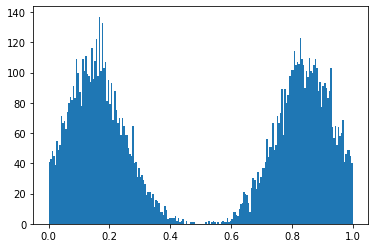

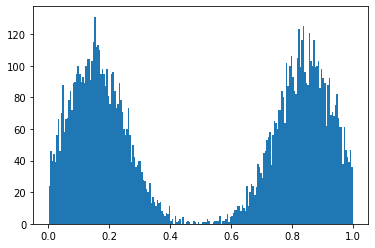

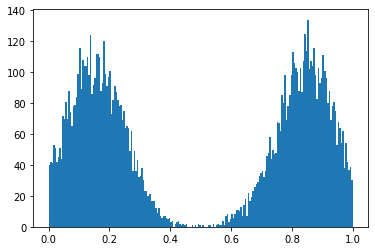

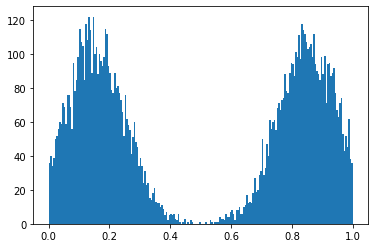

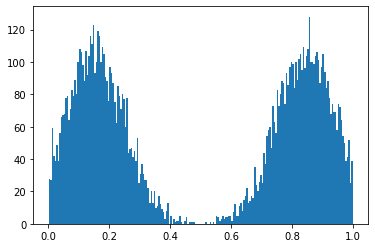

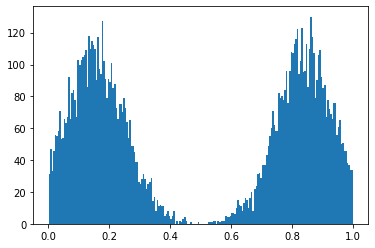

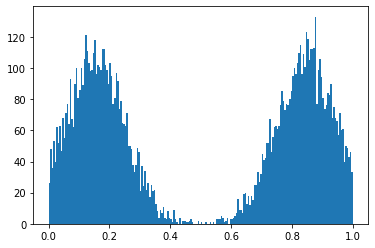

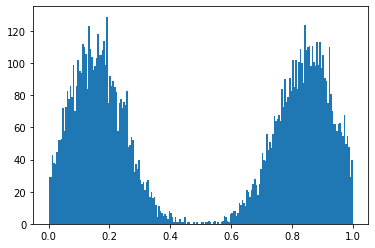

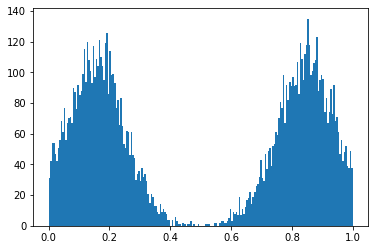

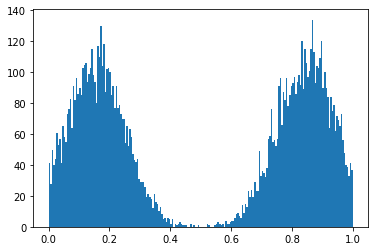

1000
9000
max_delay 0.7079178216105656
sum_delay 3.4877142572128412


In [8]:
seed = 7
np.random.seed(seed)
exec(open('distribution/twopeaknormal.py').read())

X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
run_GCSOD()

In [9]:
Agent_number_n=10

[0.06925207 0.35707063 0.81282955 0.42770483 0.59985444 0.72816128
 0.82122761 0.76051512 0.00714328 0.42025683]
[[0.97347557 0.95538345 0.42462553 ... 0.63650234 0.76108474 0.18802993]
 [0.23783677 0.66459076 0.3741999  ... 0.21199017 0.93517469 0.31604711]
 [0.45861424 0.9552804  0.6050889  ... 0.13753772 0.24868187 0.3719452 ]
 ...
 [0.36591559 0.68718776 0.09936429 ... 0.96846719 0.54219851 0.25576897]
 [0.2871301  0.10456257 0.08067045 ... 0.14154302 0.6780894  0.82744162]
 [0.19329161 0.93503464 0.27339873 ... 0.50301997 0.57779921 0.1298519 ]]
[0.97347557 0.23783677 0.45861424 ... 0.36591559 0.2871301  0.19329161]


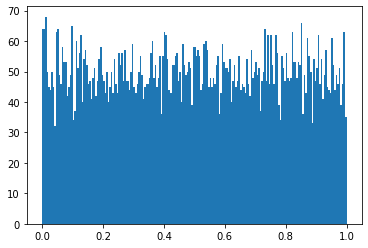

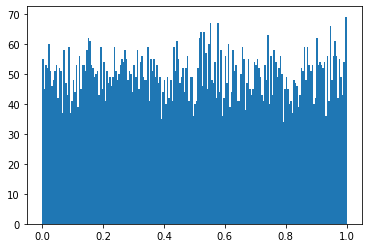

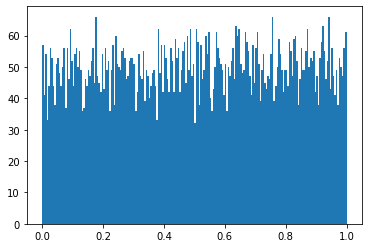

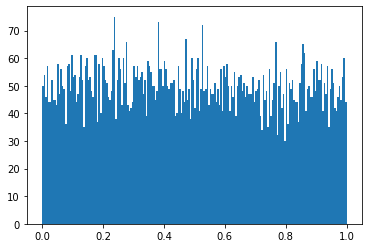

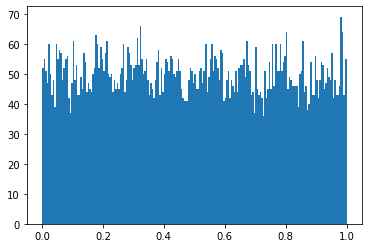

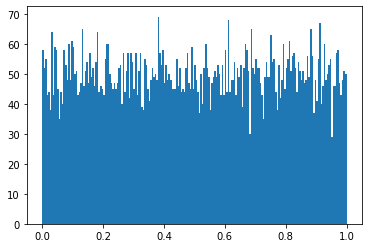

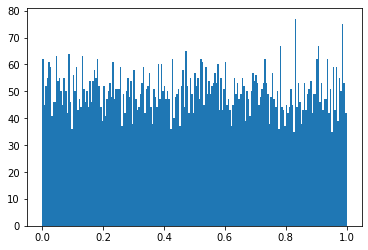

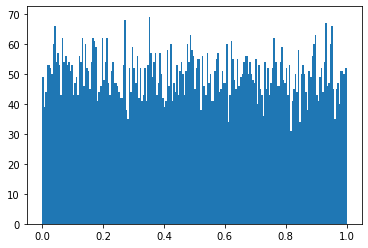

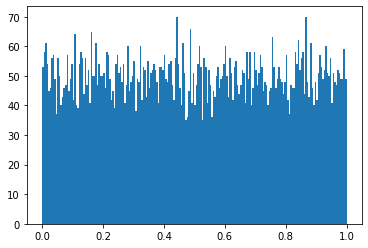

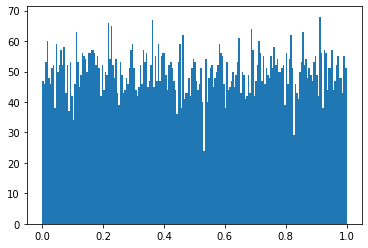

1000
9000
max_delay 0.690618016344507
sum_delay 3.0570602011993535


In [10]:
seed = 7
np.random.seed(seed)
exec(open('distribution/uniform.py').read())

X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
run_GCSOD()

[0.46079454 0.38184604 0.44005775 0.75937704 0.80591593 0.63388364
 0.60974902 0.6353258  0.49755156 0.48486731]
[[0.87201113 0.20054527 0.59526754 ... 0.33755828 0.33658395 0.53846154]
 [0.47846659 0.21971507 0.46661005 ... 0.69515653 0.40636836 0.30079682]
 [0.56450355 0.21218269 0.57814536 ... 0.28712334 0.21701084 0.37076454]
 ...
 [0.39557357 0.62140959 0.36981403 ... 0.54457435 0.50170501 0.32225437]
 [0.57262304 0.62922796 0.61420577 ... 0.38864646 0.50550212 0.69513955]
 [0.57434091 0.15524742 0.74025506 ... 0.48198306 0.50895046 0.47774852]]
[0.87201113 0.47846659 0.56450355 ... 0.39557357 0.57262304 0.57434091]


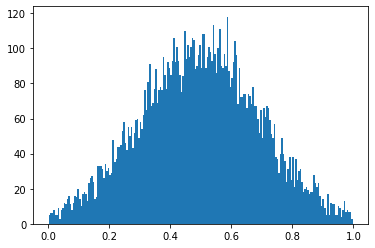

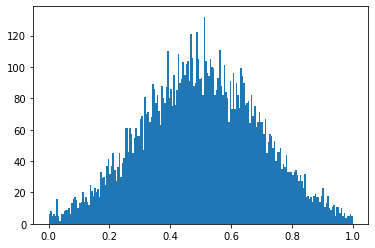

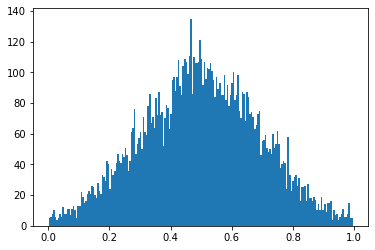

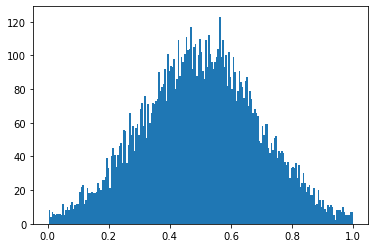

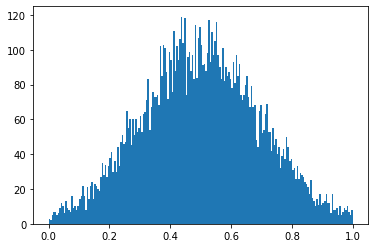

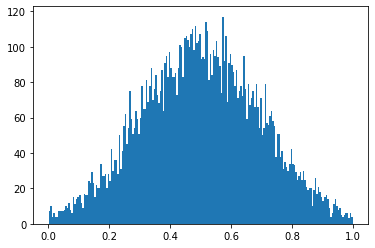

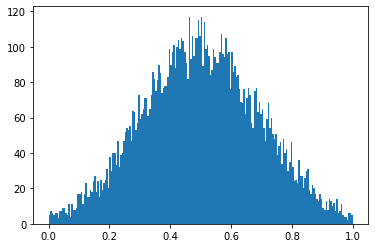

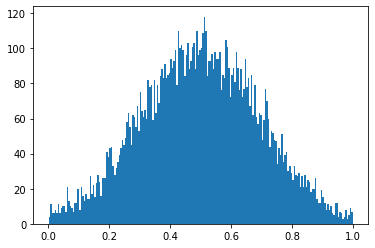

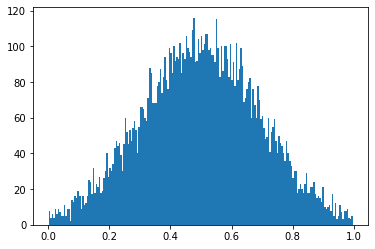

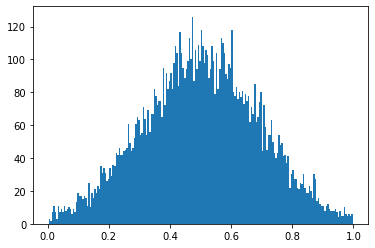

1000
9000
max_delay 0.542553179825642
sum_delay 2.2222004398312696


In [11]:
seed = 7
np.random.seed(seed)
exec(open('distribution/normal.py').read())

X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
run_GCSOD()

[0.13039727 0.79092302 0.82002888 0.27968852 0.30295796 0.21694182
 0.20487451 0.2176629  0.84877578 0.14243365]
[[0.70027264 0.89763377 0.26122905 ... 0.76829198 0.16923077 0.84090187]
 [0.94541152 0.13330503 0.82701961 ... 0.10318418 0.05039841 0.84808936]
 [0.2128368  0.18907268 0.70587925 ... 0.08538227 0.03762676 0.79102375]
 ...
 [0.22593006 0.17885102 0.16094768 ... 0.92077558 0.94185919 0.29069499]
 [0.91988353 0.22890715 0.23064907 ... 0.80403124 0.79949118 0.95067424]
 [0.78662305 0.80546595 0.06926469 ... 0.83945813 0.8712121  0.92819629]]
[0.70027264 0.94541152 0.2128368  ... 0.22593006 0.91988353 0.78662305]


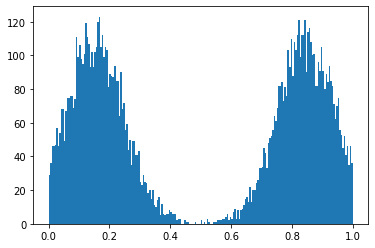

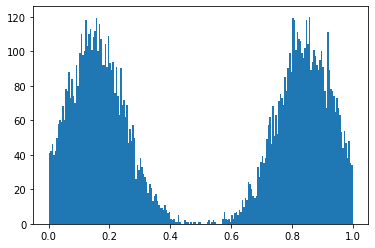

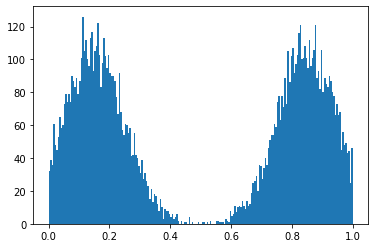

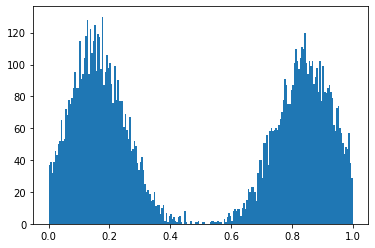

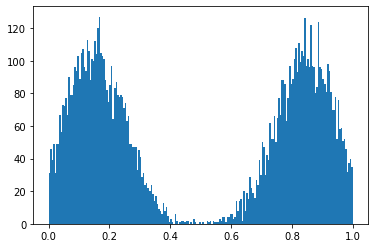

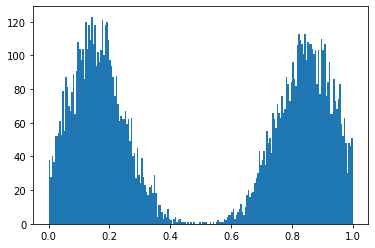

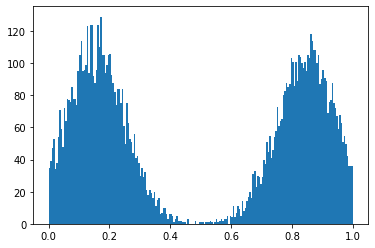

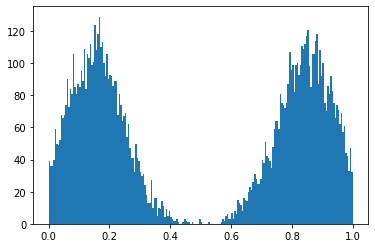

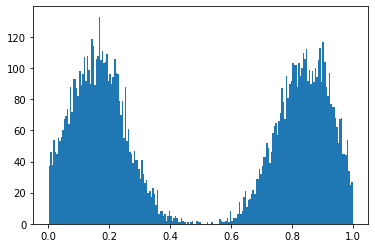

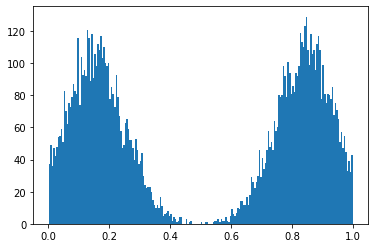

1000
9000
max_delay 0.7161354588961687
sum_delay 3.4972681896217277


In [12]:
seed = 7
np.random.seed(seed)
exec(open('distribution/twopeaknormal.py').read())

X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
run_GCSOD()